# Bitcoin Marketplace Rating Predictions

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
plt.style.use('ggplot')

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v
import time

## OTC features

In [2]:
df_otc_features = pd.read_csv('../data/df_features_otc.csv')
df_otc_velocity = pd.read_csv('../data/df_otc_vd.csv')

merge_cols = ['ratee','rater','date','rating','class']
features_df = pd.merge(df_otc_features, df_otc_velocity, on=merge_cols)

features_df.drop(['binomial_rating', 'color', 'penwidth'], inplace=True, axis=1)

## Fit Model

In [3]:
X = features_df.copy()
X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
r = X['rating_received_avg']
y = X.pop('class')
X_train, X_test, y_train, y_test, r_train, r_test = train_test_split(X, y, r,
                                                    stratify=y, shuffle=True,
                                                    random_state=123)

model = RandomForestClassifier(bootstrap = True,
                               max_depth = 15,
                               max_features = 4,
                               min_samples_leaf = 3,
                               min_samples_split = 7,
                               n_estimators = 1000,
                               n_jobs=-1,
                               random_state=123)
model.fit(X_train, y_train)

rf_pred = model.predict(X_test)
rf_proba = model.predict_proba(X_test)[:,1]

rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, rf_proba)
rf_f1 = f1_score(y_test, rf_pred)

### Precision and Recall from Using Average User Rating

In [4]:
# Average user rating for ROC AUC scores
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

r_pred = (r_test<0).astype(int)
r_proba = NormalizeData(r_test)

r_precision, r_recall, r_thresholds = precision_recall_curve(y_test, r_pred)
r_f1 = f1_score(y_test, r_pred)

### Fit Model with no graph features

In [5]:
graph_cols = ['ego_triad_300', 'ego_triad_210', 'ego_triad_201', 
              'ego_triad_120', 'ego_triad_all', 'ego_cluster_coef', 
              'ego_degree', 'ego_betweeness', 'ego_closeness', 'ego_num_cliques']
features_df_ng = features_df.copy()
features_df_ng.drop(graph_cols, inplace=True, axis=1)

X = features_df_ng.copy()
X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
r = X['rating_received_avg']
y = X.pop('class')
X_train, X_test, y_train, y_test, r_train, r_test = train_test_split(X, y, r, 
                                                    stratify=y, shuffle=True,
                                                    random_state=123)
model_ng = RandomForestClassifier(
                               bootstrap = True,
                               max_depth = 15,
                               max_features = 4,
                               min_samples_leaf = 3,
                               min_samples_split = 7,
                               n_estimators = 1000,
                               n_jobs=-1,
                               random_state=123)
model_ng.fit(X_train, y_train)

ng_pred = model_ng.predict(X_test)
ng_proba = model_ng.predict_proba(X_test)[:,1]

ng_precision, ng_recall, ng_thresholds = precision_recall_curve(y_test, ng_proba)
ng_f1 = f1_score(y_test, ng_pred)

### Precision Recall Curve

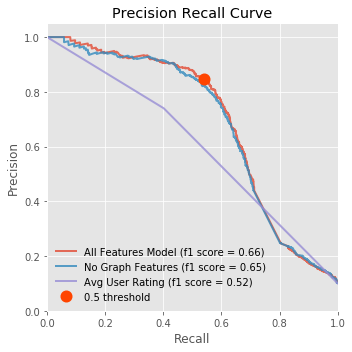

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
thresh1 = .5
rf_threshold_idx1 = np.argmin(np.abs(rf_thresholds-thresh1))
ax.set_title("Precision Recall Curve")
ax.plot(rf_recall, rf_precision, alpha=0.8, linewidth=2.0,label=f"All Features Model (f1 score = {rf_f1:.2f})")
ax.plot(ng_recall, ng_precision, alpha=0.8, linewidth=2.0,label=f"No Graph Features (f1 score = {ng_f1:.2f})")
ax.plot(r_recall, r_precision, alpha=0.8, linewidth=2.0,label=f"Avg User Rating (f1 score = {r_f1:.2f})")
plt.plot(rf_recall[rf_threshold_idx1], 
         rf_precision[rf_threshold_idx1], 'o', 
         markersize=10, fillstyle='full', 
         c="orangered", label=f"{thresh1} threshold", mew=2)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(loc="lower left", frameon=False)
plt.tight_layout()

### Confusion Matrix

In [7]:
from sklearn.metrics import confusion_matrix

thresh = .5
pred_proba = rf_proba
cnf_matrix = confusion_matrix(y_test, pred_proba>=thresh)
print(cnf_matrix)
tn, fp, fn, tp = cnf_matrix.ravel()
neg = tn + fp
pos = fn + tp
tnpct = tn/neg
fppct = fp/neg
fnpct = fn/pos
tppct = tp/pos
cnt_matrix_pct = np.round(np.array([tnpct,fppct,fnpct, tppct]), 2)
cnt_matrix_pct.reshape((2,2))

[[7919   88]
 [ 411  480]]


array([[0.99, 0.01],
       [0.46, 0.54]])

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.98900962 0.01099038]
 [0.46127946 0.53872054]]


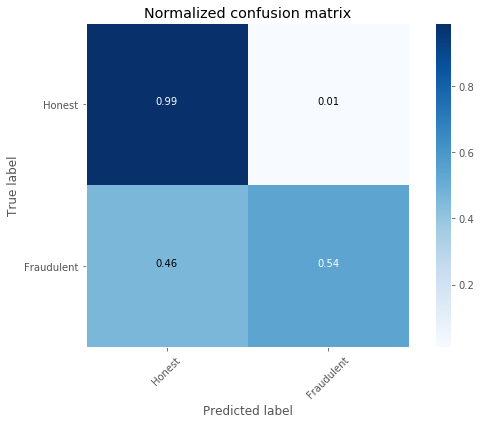

In [9]:
plt.figure(figsize=(8,6))
target_names = ['Honest','Fraudulent']
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

### Collusion Example

In [10]:
# Predict on Example 
x_pred = features_df[(features_df['ratee']==4986)].copy()
model = RandomForestClassifier(n_jobs=-1,
                               random_state=123)
model.fit(X_train, y_train)
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date', 'class'], axis=1, inplace=True)

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features

ValueError: Number of features of the model must match the input. Model n_features is 12 and input n_features is 22 

In [ ]:
# Predict on Example (with no features)
model_ng = RandomForestClassifier(n_jobs=-1,
                                  random_state=123)
model_ng.fit(X_train, y_train)
x = features_df_ng[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date', 'class'], axis=1, inplace=True)

In [ ]:
x_pred = features_df_ng[(features_df_ng['ratee']==4986)].copy()

x = x_pred.drop(['rater', 'ratee', 'rating','date'], axis=1)
y = x.pop('class')

# run model without graph features
pred_no_features = model_ng.predict_proba(x)[:,1]
x_pred = x_pred[['ratee','date','rating']]
x_pred['prediction_without_features'] = pred_no_features

In [ ]:
# rerun model with graph features
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date'], axis=1, inplace=True)
y = x.pop('class')

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features
x_pred

### Feature Importance

In [ ]:
features=X.columns
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(4,6))
ax.set_title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color=['m','m','m','y','y','m','m','m','m','m','m','m','c','c','c','y','c','y','y','c','c','y'], 
         align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()